In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import data_tools
import xarray as xr
import pandas as pd
import datetime
import glob
from salishsea_tools import nc_tools
import os
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline

In [86]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Getting and binning CHS data

In [2]:
SC = data_tools.get_chs_tides('obs', 'Sandy Cove', '2017-11-30 00:05:00', '2018-01-08 23:54:00')

In [3]:
SC.shape

(56752,)

In [4]:
times = np.array([datetime.datetime(2017,11,30,0,0) 
                  + datetime.timedelta(minutes = n*10) for n in range(5761)])
times[-1]

datetime.datetime(2018, 1, 9, 0, 0)

In [5]:
list_of_SC = np.array([])
for n in range(5760):
    binned = (SC[((SC.index >= times[n]) & (SC.index < times[n+1]))].values)
    if len(binned) == 0:
        binned = np.array([999])
    binned = binned.mean()
    list_of_SC = np.append(list_of_SC, binned)

# Getting model data

In [6]:
SC_model = (['/results/SalishSea/nowcast-green/30nov17/SandyCove.nc'] +
 sorted(glob.glob('/results/SalishSea/nowcast-green/*dec17/SandyCove.nc')) 
 + sorted(glob.glob('/results/SalishSea/nowcast-green/*jan18/SandyCove.nc'))[:8])

In [7]:
with nc_tools.scDataset(SC_model) as f:
    model = f.variables['sossheig'][:,0,0]

In [8]:
model.shape

(5760,)

# Getting correction data

In [9]:
c = pd.read_csv('/home/sallen/MEOPAR/ANALYSIS/analysis-storm-surges/notebooks/tide_analysis_scripts/Sandy Cove_tidal_prediction_01-Jan-2013_31-Dec-2020.csv', 
      header =3 , )

In [10]:
list_of_datetimes = np.array([])
for n in range(258335, 264244):
    dt = datetime.datetime.strptime(c['time '][n][:-1], '%d-%b-%Y %H:%M:%S')
    list_of_datetimes = np.append(list_of_datetimes, dt)
c = c[258335:264244]
c = c.assign(datetimes = list_of_datetimes)
c = c.assign(corr = c[' pred_noshallow '] - c[' pred_8 '])
c = c[1:-148]
print(c.shape)

(5760, 6)


In [11]:
c[:3]

,time,pred_8,pred_all,pred_noshallow,datetimes,corr
258336,30-Nov-2017 00:05:00,-0.314831,-0.318229,-0.349643,2017-11-30 00:05:00,-0.034812
258337,30-Nov-2017 00:15:00,-0.229816,-0.233436,-0.264197,2017-11-30 00:15:00,-0.034381
258338,30-Nov-2017 00:25:00,-0.146210,-0.149914,-0.180251,2017-11-30 00:25:00,-0.034041


In [12]:
c[-3:]

,time,pred_8,pred_all,pred_noshallow,datetimes,corr
264093,08-Jan-2018 23:35:00,0.244299,0.172948,0.194101,2018-01-08 23:35:00,-0.050198
264094,08-Jan-2018 23:45:00,0.231102,0.172842,0.191856,2018-01-08 23:45:00,-0.039246
264095,08-Jan-2018 23:55:00,0.213649,0.168631,0.185324,2018-01-08 23:55:00,-0.028325


In [13]:
model = model[list_of_SC < 30]
times = times[:-1][list_of_SC < 30]
c = c[list_of_SC < 30]
list_of_SC = list_of_SC[list_of_SC < 30]

In [14]:
c.shape

(5678, 6)

In [307]:
HINDCAST_PATH = '/results/SalishSea/nowcast-green/'

In [206]:
# intepolated hourly data
list_of_model_ssh = np.array([])
for n in range(56752):
    date = pd.to_datetime(SC.index[n])
    if ((date.hour == 0) & (date.minute < 5)):
        before = (datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = (23), minute = 55) - datetime.timedelta(days=1))
    elif date.minute < 5:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = date.hour-1, minute = 55)
    elif date.minute%10 < 5:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = (date.hour), minute = 10*(date.minute//10) - 5)
    else:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = (date.hour), minute = 10*(date.minute//10) + 5)  
    delta = (date - before).seconds / 600
    after = before + datetime.timedelta(minutes = 10)
    subdir = before.strftime('%d%b%y').lower()
    file = nc.Dataset(os.path.join(HINDCAST_PATH, subdir, 'SandyCove.nc'))
    subdir2 = after.strftime('%d%b%y').lower()
    file2 = nc.Dataset(os.path.join(HINDCAST_PATH, subdir2, 'SandyCove.nc'))
    corr = ((1-delta) * f[f.datetimes == before]['corr'].values[0] + 
           delta * f[f.datetimes == after]['corr'].values[0])
    s_val = ((1-delta) * file.variables['sossheig'][before.hour*6 + before.minute//10] + 
           delta*file2.variables['sossheig'][after.hour*6 + after.minute//10]) + corr + 3.09
    list_of_model_ssh = np.append(list_of_model_ssh, s_val)

In [15]:
from matplotlib.colors import LogNorm

In [16]:
list_of_SC.shape

(5678,)

In [18]:
corr = c['corr'].values
corr.shape

(5678,)

bias =  0.0257231919972
RMSE = 0.111745428965
Willmott = 0.997441682788


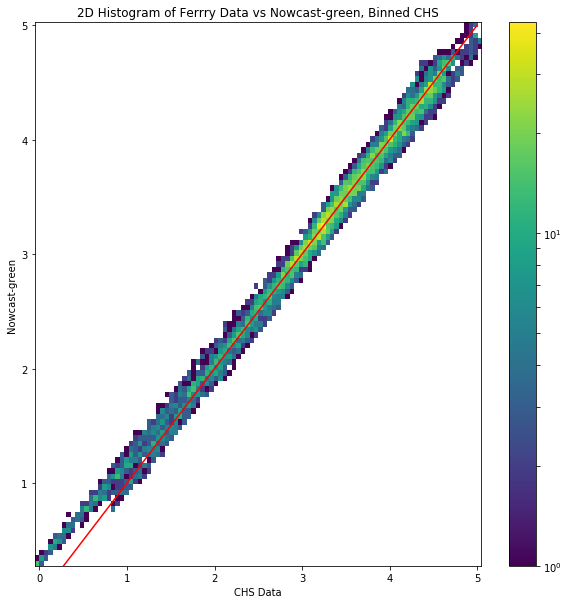

In [30]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(list_of_SC, 
                                model + 3.09 -corr, bins = 100, norm=LogNorm())
im
fig.colorbar(im, ax=ax)
ax.set_xlabel('CHS Data')
ax.set_ylabel('Nowcast-green')
ax.set_title('2D Histogram of Ferrry Data vs Nowcast-green, Binned CHS')
ax.plot(np.arange(-1,6),np.arange(-1, 6), 'r')
obs = list_of_SC
print('bias =  ' + str(-np.mean(obs) + np.mean(model+3.09 -corr)))
print('RMSE = ' + str(np.sqrt(np.sum(((model+3.09- corr) - obs)**2) / len(model))))
xbar = np.mean(obs)
print('Willmott = ' + str(1-(np.sum(((model+3.09 - corr) - obs)**2)  / 
                             np.sum((np.abs((model+3.09 - corr) - xbar) 
                                     + np.abs(obs - xbar))**2))))

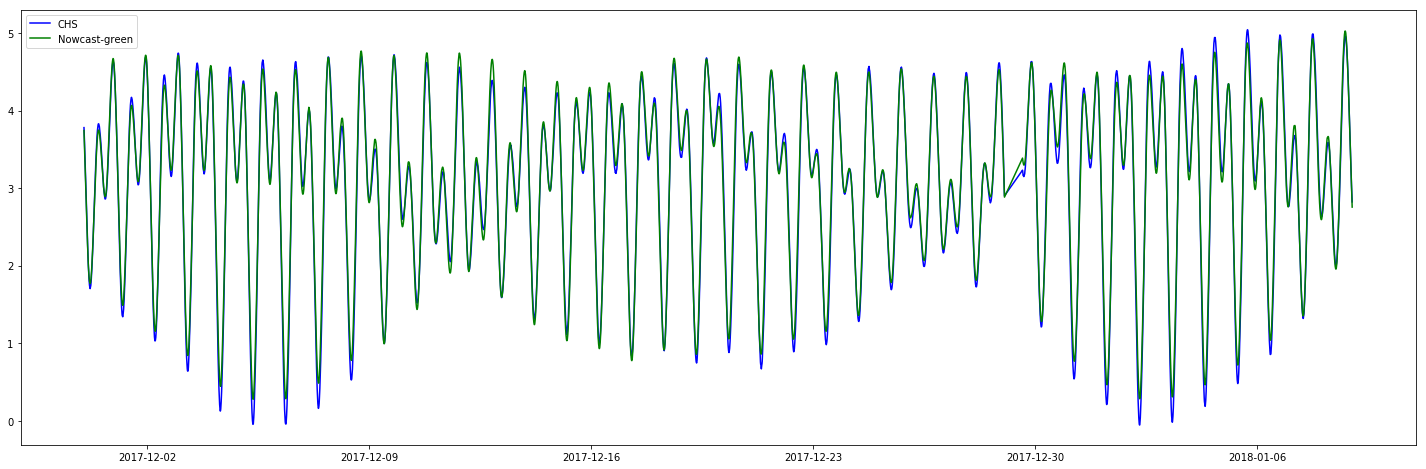

In [31]:
fig, ax = plt.subplots(figsize = (25,8))
ax.plot(times + datetime.timedelta(minutes = 5), list_of_SC, 'b', label = 'CHS')
ax.plot(times + datetime.timedelta(minutes = 5), model + 3.09 - corr, 
        'g', label = 'Nowcast-green')
ax.legend()

# No correction

bias =  0.0245183362382
RMSE = 0.123067125316
Willmott = 0.996797143041


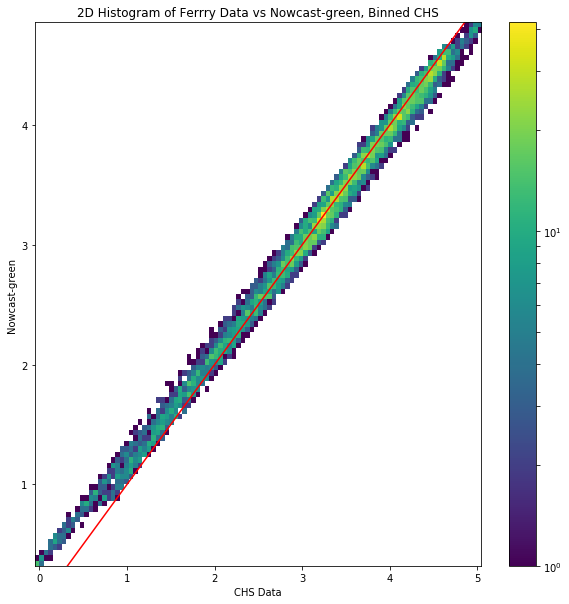

In [21]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(list_of_SC, 
                                model + 3.09 , bins = 100, norm=LogNorm())
im
fig.colorbar(im, ax=ax)
ax.set_xlabel('CHS Data')
ax.set_ylabel('Nowcast-green')
ax.set_title('2D Histogram of Ferrry Data vs Nowcast-green, Binned CHS')
ax.plot(np.arange(-1,6),np.arange(-1, 6), 'r')
obs = list_of_SC
print('bias =  ' + str(-np.mean(obs) + np.mean(model+3.09)))
print('RMSE = ' + str(np.sqrt(np.sum(((model+3.09) - obs)**2) / len(model))))
xbar = np.mean(obs)
print('Willmott = ' + str(1-(np.sum(((model+3.09) - obs)**2)  / 
                             np.sum((np.abs((model+3.09) - xbar) 
                                     + np.abs(obs - xbar))**2))))

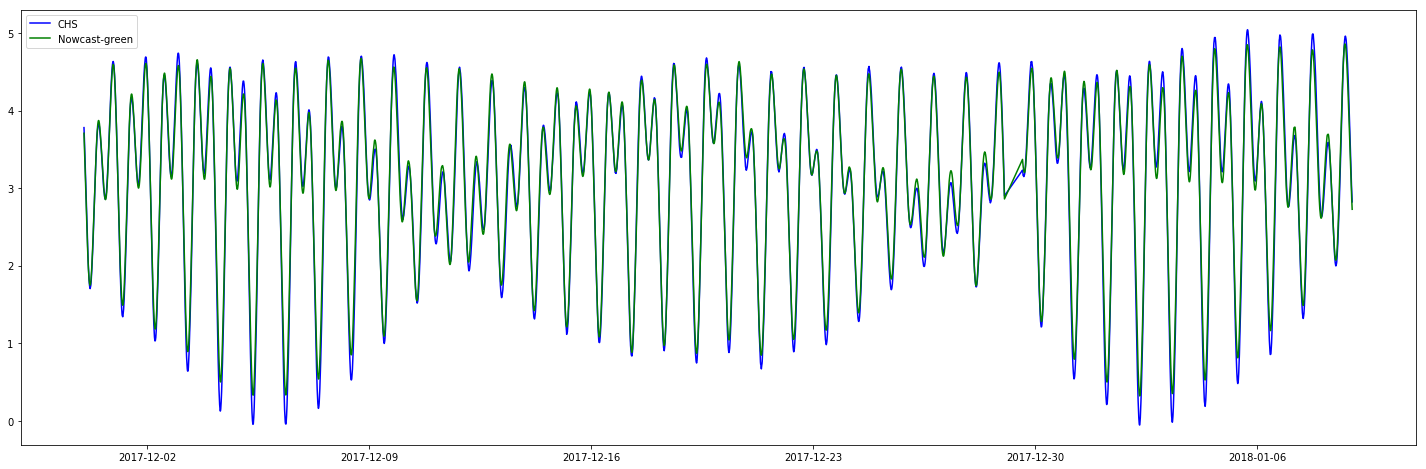

In [22]:
fig, ax = plt.subplots(figsize = (25,8))
ax.plot(times + datetime.timedelta(minutes = 5), list_of_SC, 'b', label = 'CHS')
ax.plot(times + datetime.timedelta(minutes = 5), model + 3.09, 
        'g', label = 'Nowcast-green')
ax.legend()

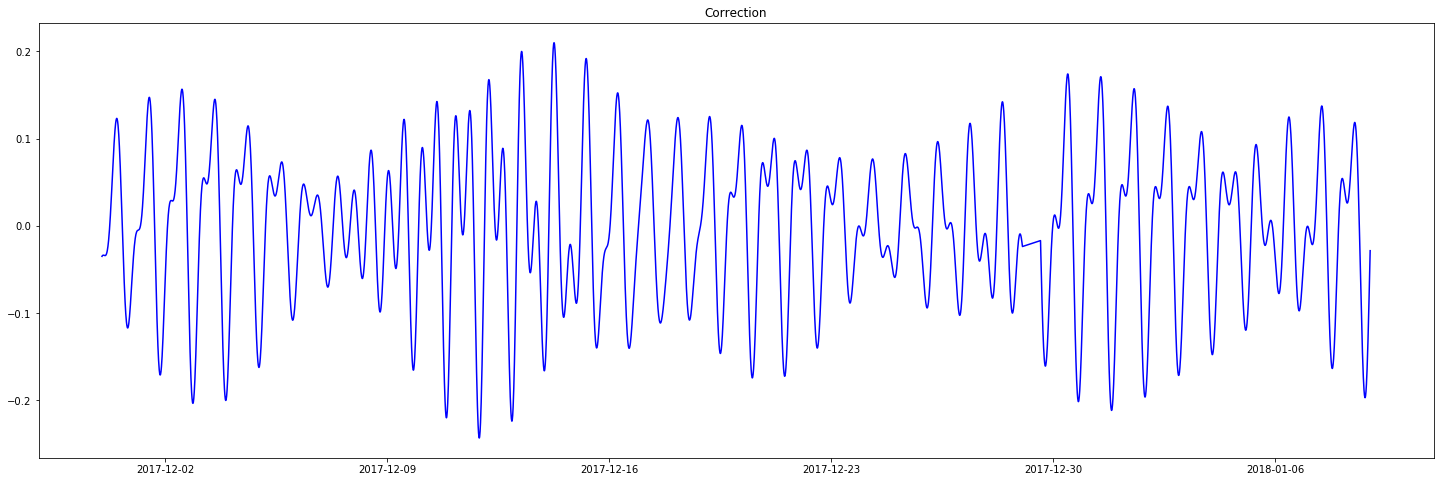

In [27]:
fig, ax = plt.subplots(figsize = (25,8))
ax.plot(times + datetime.timedelta(minutes = 5), corr, 'b', label = 'correction')
ax.set_title('Correction')

/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0, 1)

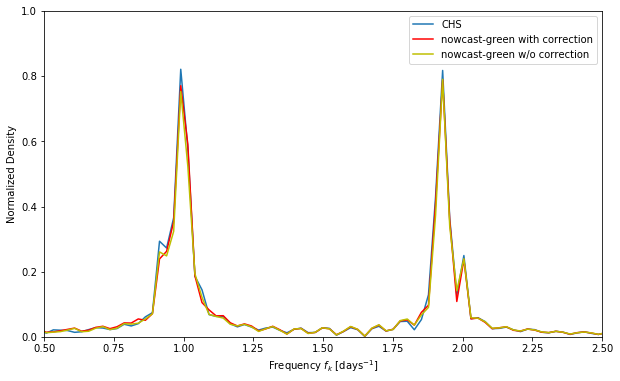

In [32]:
rate = 1/(24 * 6)
n = len(list_of_SC)
f = np.linspace(0, 1/(2*rate), n/2)
C = np.fft.fft(list_of_SC)
C_norm = 2/n * np.abs(C[:n/2])

# Plot spectral density periodigram
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(f, C_norm, label = 'CHS')
ax.set_xlim([0, 5])
ax.set_xlabel('Frequency $f_k$ [days$^{-1}$]')
ax.set_ylabel('Normalized Density')

rate = 1/(24 * 6)
n = len(model)
f = np.linspace(0, 1/(2*rate), n/2)
C = np.fft.fft(model + 3.09 - corr)
C_norm = 2/n * np.abs(C[:n/2])

ax.plot(f, C_norm, 'r', label = 'nowcast-green with correction')

C = np.fft.fft(model + 3.09)
C_norm = 2/n * np.abs(C[:n/2])

ax.plot(f, C_norm, 'y', label = 'nowcast-green w/o correction')
ax.legend()

ax.set_xlim(0.5, 2.5)
ax.set_ylim(0, 1)